# Linear Bivariate BMM with calibration of Coleman toy models.

The best way to learn Taweret is to use it. You can run, modify and experiment with this notebook [here.](https://mybinder.org/v2/gh/danOSU/Taweret/c2d8fd3ce3d74a5891d51adb5afc0afa0b503127?urlpath=lab%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2FLinear_BMM_with_cdf_function_for_coleman_models.ipynb)


The models can be found in Coleman Thesis : https://go.exlibris.link/3fVZCfhl

This notebook shows how to use the Bayesian model mixing package **Taweret** for a toy problem. 

**Author : Dan Liyanage**

Date : 11/13/2022

In [1]:
import sys

# You will have to change the following imports depending on where you have 
# the packages installed

# If using binder please uncomment the following.
#sys.path.append("/home/jovyan/")

sys.path.append("/Users/dananjayaliyanage/temp/Taweret")

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
# To define priors. (uncoment if not using default priors)
#import bilby

# For other operations
import numpy as np

In [2]:
# Import models with a predict method
from Taweret.models import coleman_models as toy_models

m1 = toy_models.coleman_model_1()
m2 = toy_models.coleman_model_2()
truth = toy_models.coleman_truth()

In [3]:
g = np.linspace(-1,9,10)
plot_g = np.linspace(-1,9,100)
true_output = truth.evaluate(plot_g)
exp_data = truth.evaluate(g)

## 1. The models and the experimental data.

Truth
 
$f(x) = 2-0.1(x-4)^2$, where $x \in [-1, 9]$

Model 1

$f_1(x,\theta)= 0.5(x+\theta)-2$    , where $\theta \in [1, 6]$

Model 2

$f_2(x,\theta)= -0.5(x-\theta) + 3.7$   , where $\theta \in [-2, 3]$

Experimental data 

sampled from the Truth with a fixed standard deviation of 0.3




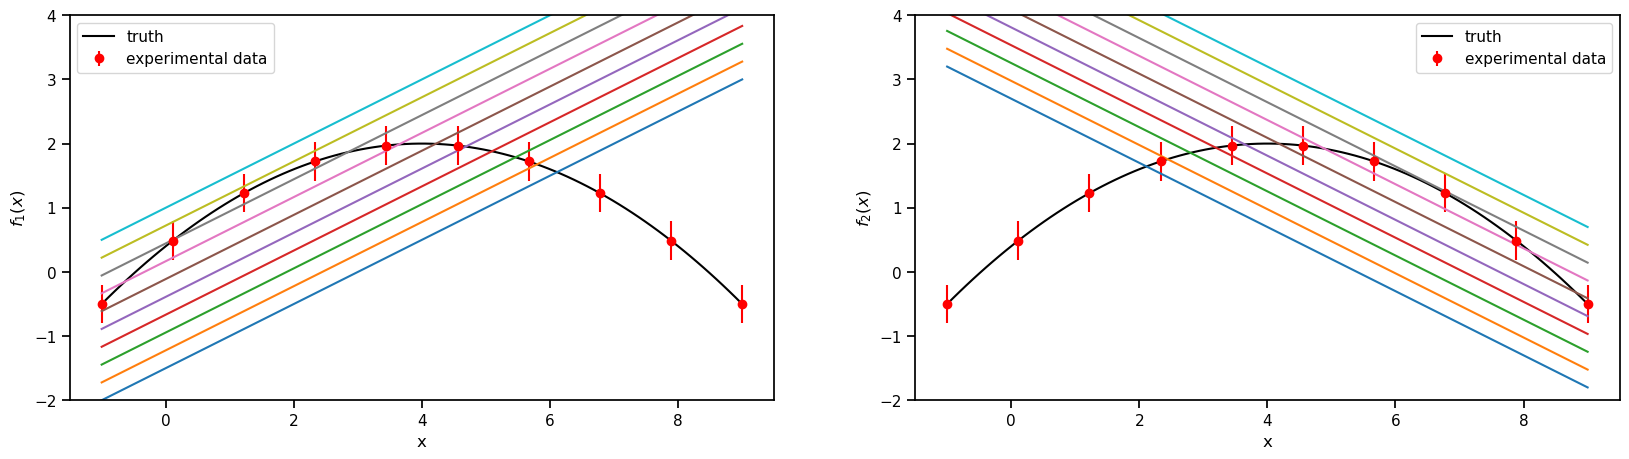

In [4]:
sns.set_context('notebook')
fig, axs = plt.subplots(1,2,figsize=(20,5))
prior_ranges = [(1,6), (-2,3)]
for i in range(0,2):
    ax = axs.flatten()[i]
    ax.plot(plot_g, true_output[0], label='truth', color='black')
    ax.errorbar(g,exp_data[0],exp_data[1], fmt='o', label='experimental data', color='r')
    ax.legend()
    ax.set_ylim(-2,4)
    for value in np.linspace(*prior_ranges[i],10):
        if i==0:
            predict_1 = m1.evaluate(plot_g, value)
            ax.plot(plot_g, predict_1[0])
            ax.set_ylabel(r'$f_1(x)$')
        if i==1:
            predict_2 = m2.evaluate(plot_g, value)
            ax.plot(plot_g, predict_2[0])      
            ax.set_ylabel(r'$f_2(x)$')    
    ax.set_xlabel('x') 
    


##  2. Choose a Mixing method

In [5]:
# Mixing method
from Taweret.mix.bivariate_linear import BivariateLinear as BL

models= {'model1':m1,'model2':m2}
mix_model = BL(models_dic=models, method='cdf', nargs_model_dic={'model1':1, 'model2':1})

cdf mixing function has 2                   free parameter(s)
To change the prior use `set_prior` method
Using default priors for model 1
{'model1_0': Uniform(minimum=1, maximum=6, name='model1_0', latex_label='model1_0', unit=None, boundary=None)}
Using default priors for model 2
{'model2_0': Uniform(minimum=-2, maximum=3, name='model2_0', latex_label='model2_0', unit=None, boundary=None)}


In [6]:
## uncoment to change the prior from the default
import bilby 

priors = bilby.core.prior.PriorDict()
priors['cdf_0'] = bilby.core.prior.Normal(0, 1, name="cdf_0")
priors['cdf_1'] = bilby.core.prior.Normal(0, 1, name="cdf_1")
mix_model.set_prior(priors)

{'cdf_0': Normal(mu=0, sigma=1, name='cdf_0', latex_label='cdf_0', unit=None, boundary=None),
 'cdf_1': Normal(mu=0, sigma=1, name='cdf_1', latex_label='cdf_1', unit=None, boundary=None),
 'model1_0': Uniform(minimum=1, maximum=6, name='model1_0', latex_label='model1_0', unit=None, boundary=None),
 'model2_0': Uniform(minimum=-2, maximum=3, name='model2_0', latex_label='model2_0', unit=None, boundary=None)}

In [7]:
mix_model.prior

{'cdf_0': Normal(mu=0, sigma=1, name='cdf_0', latex_label='cdf_0', unit=None, boundary=None),
 'cdf_1': Normal(mu=0, sigma=1, name='cdf_1', latex_label='cdf_1', unit=None, boundary=None),
 'model1_0': Uniform(minimum=1, maximum=6, name='model1_0', latex_label='model1_0', unit=None, boundary=None),
 'model2_0': Uniform(minimum=-2, maximum=3, name='model2_0', latex_label='model2_0', unit=None, boundary=None)}

## 3. Train to find posterior

In [8]:
result = mix_model.train(x_exp=g, y_exp=exp_data[0], y_err=exp_data[1], label='cdf_mix', 
                         outdir='outdir/coleman', load_previous=True)

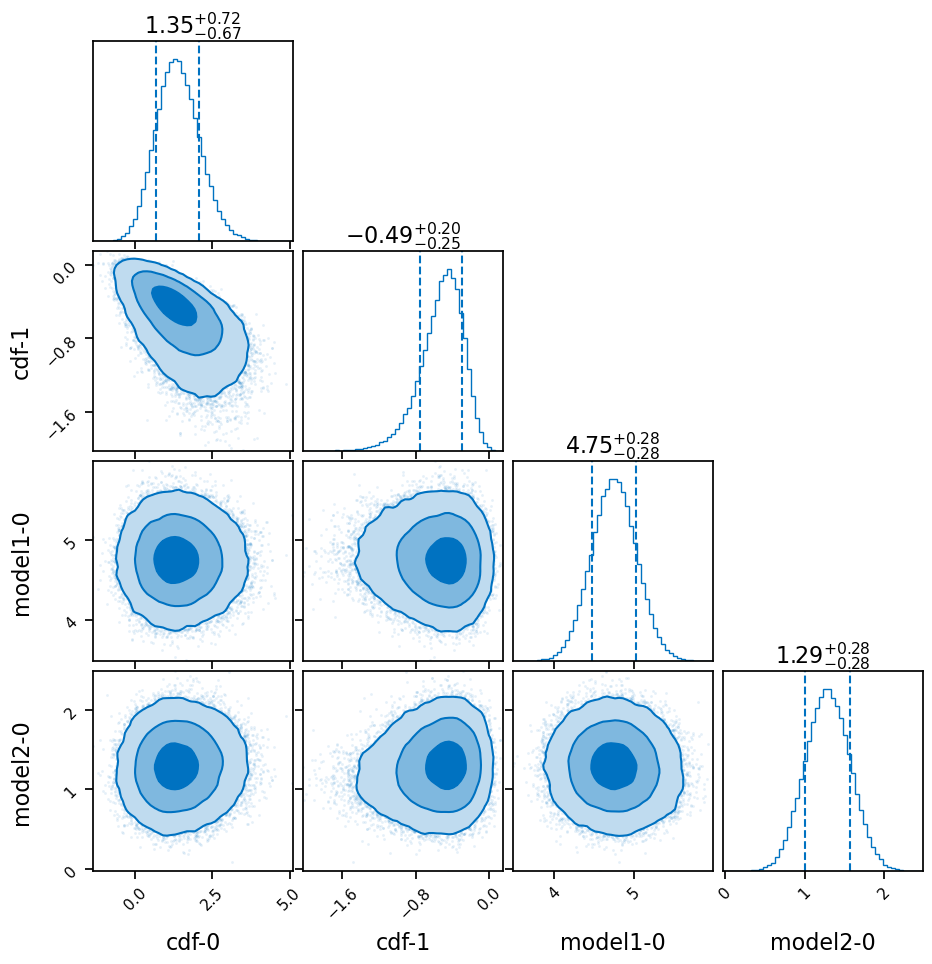

In [9]:
result.plot_corner()

### 4. Predictions

In [10]:
_,mean_prior,CI_prior, _ = mix_model.prior_predict(plot_g, CI=[5,20,80,95])
_,mean,CI, _ = mix_model.predict(plot_g, CI=[5,20,80,95])

(10000, 4)
using provided samples instead of posterior


In [11]:
per5, per20, per80, per95 = CI
prior5, prior20, prior80, prior95 = CI_prior

In [12]:
mix_model.map

array([ 5.10883979, -1.20865142,  4.71479062,  1.43596136])

In [13]:
# Map value prediction for the step mixing function parameter
model_params = [np.array(mix_model.map[2]), np.array(mix_model.map[3])]
map_prediction = mix_model.evaluate(mix_model.map[0:2], plot_g, model_params=model_params)

In [14]:
_,_,CI_weights,_=mix_model.predict_weights(plot_g, CI=[5,20, 80, 95])
perw_5, perw_20, perw_80, perw_95 = CI_weights

(100400, 100)


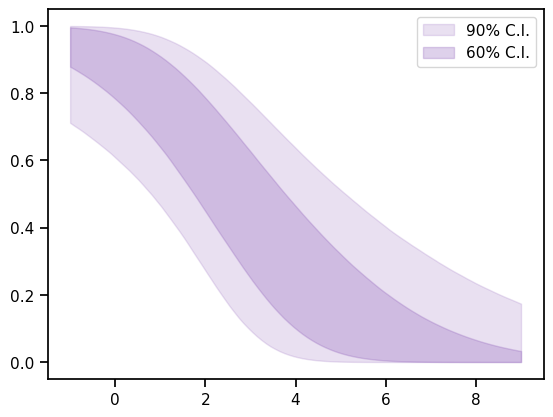

In [15]:
%matplotlib inline
fig, ax = plt.subplots()
ax.fill_between(plot_g,perw_5,perw_95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,perw_20,perw_80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.legend()
#ax.plot(plot_g, true_output[0], label='truth')
#ax.set_ylim(1.2,3.2)

ValueError: 'y1' is not 1-dimensional

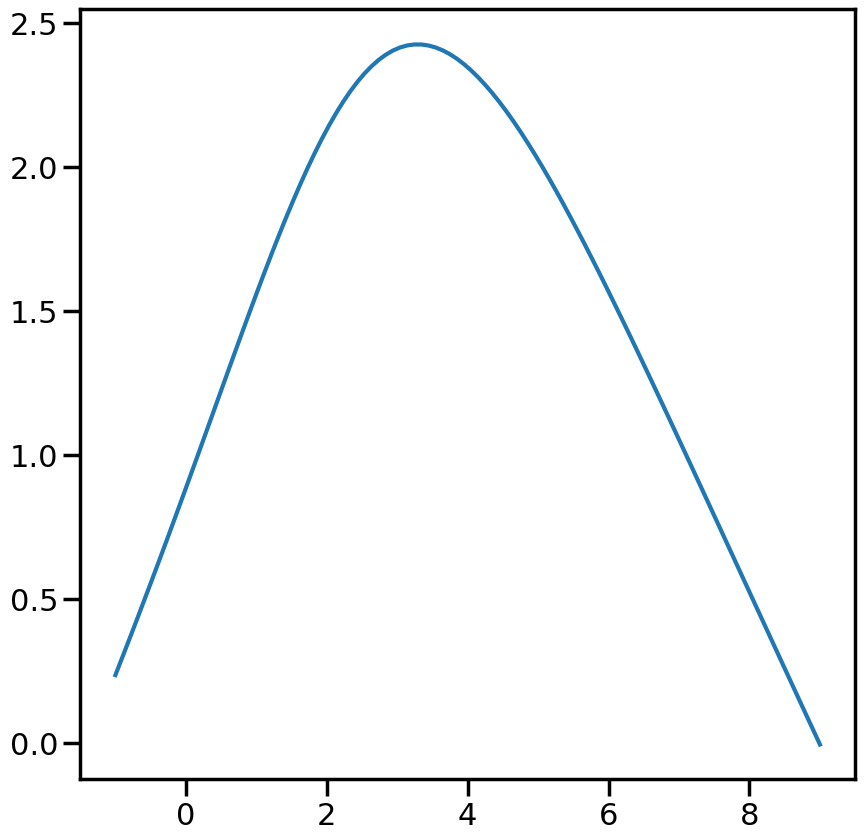

In [17]:
%matplotlib inline
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(plot_g, mean.flatten(), label='posterior mean')
ax.fill_between(plot_g,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.fill_between(plot_g,prior20,prior80,color=sns.color_palette()[2], alpha=0.2, label='60% C.I. Prior')
ax.errorbar(g,exp_data[0],yerr=exp_data[1], marker='x', label='experimental data')
ax.plot(plot_g, mean_prior, label='prior mean')
ax.plot(plot_g, map_prediction.flatten(), label='MAP prediction')
ax.set_ybound(-2,4)
ax.legend()